<a href="https://colab.research.google.com/github/majdkhalife/StockPredictor/blob/main/StockPredictor_Arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The ARIMA model is a widely used model as it can identify complex patterns of past observations, with future needs which makes it a state of the art technique.


The key components of an ARIMA model


*   The Autoregressive (AR) component builds a trend from past values in the AR framework for predictive models. For clarification, the 'autoregression framework' works like a regression model where you use the lags of the time series' own past values as the regressors.


*    The Integrated (I) part involves the differencing of the time series component keeping in mind that our time series should be stationary, which really means that the mean and variance should remain constant over a period of time.


* The moving average (MA) component focuses on the relationship between an observation and a residual error. Looking at how the present observation is related to those of the past errors, we can then infer some helpful information about any possible trend in our data.





## Load dataset and import libraries

In [1]:
!pip install yfinance --quiet
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
data = yf.download("JNJ", start="2010-01-01", end="2024-01-01")
data.fillna(method='ffill', inplace=True)

[*********************100%***********************]  1 of 1 completed
<ipython-input-2-320ee17e99a3>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [3]:
# Augmented Dickey-Fuller test for stationarity
result = adfuller(data["Close"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.1806824524162733
p-value: 0.6818499468050622


In [4]:
if result[1] > 0.05:
    print("Series is non-stationary. Differencing the data.")
    differenced_data = data["Close"].diff().dropna()
    result = adfuller(differenced_data)
    stationarity_interpretation = "Stationary after differencing" if result[1] < 0.05 else "Non-Stationary even after differencing"
    print(f"ADF Statistic after differencing: {result[0]}")
    print(f"p-value after differencing: {result[1]}")
else:
    stationarity_interpretation = "Stationary"
    print("Series is stationary. No differencing needed.")

print(f"Interpretation: The series is {stationarity_interpretation}.")

Series is non-stationary. Differencing the data.
ADF Statistic after differencing: -19.341525227824892
p-value after differencing: 0.0
Interpretation: The series is Stationary after differencing.


<Figure size 1200x600 with 0 Axes>

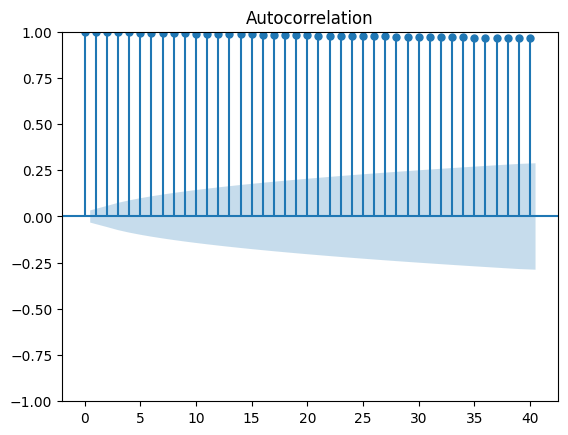

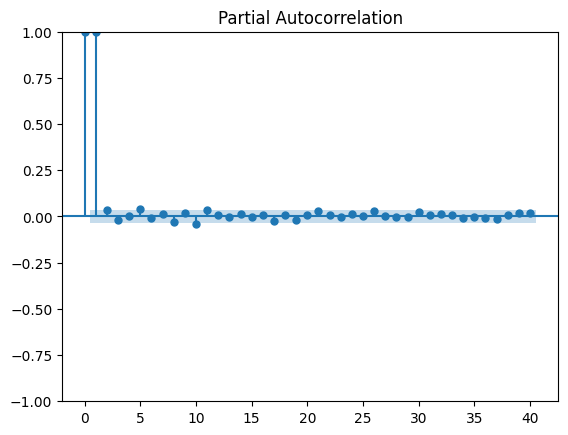

In [5]:
plt.figure(figsize=(12, 6))
if result[1] < 0.05:
    plot_acf(data["Close"], lags=40)
    plot_pacf(data["Close"], lags=40)
else:
    plot_acf(differenced_data, lags=40)
    plot_pacf(differenced_data, lags=40)
plt.show()

In [52]:
# Model fitting
p, d, q = 2, 2, 23  #choose p to be 1 or 2 as we observe two large spikes for the PACF, and then becomes negligible. for d,
model = ARIMA(data["Close"], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/pyth

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3522
Model:                ARIMA(2, 2, 23)   Log Likelihood               -6021.039
Date:                Tue, 15 Oct 2024   AIC                          12094.079
Time:                        05:18:33   BIC                          12254.401
Sample:                             0   HQIC                         12151.279
                               - 3522                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7985      0.004   -416.947      0.000      -1.807      -1.790
ar.L2         -0.9896      0.004   -219.927      0.000      -0.998      -0.981
ma.L1          0.7459      0.202      3.691      0.0

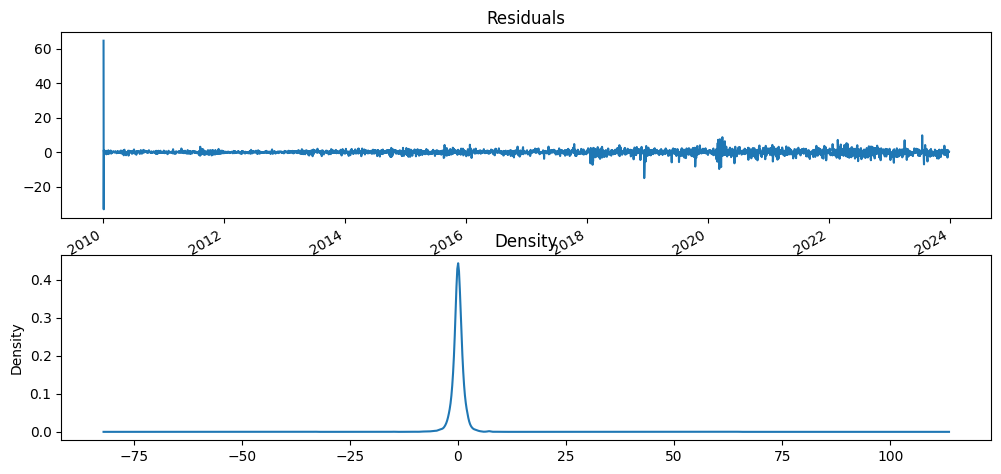

AIC: 12094.078910518721
BIC: 12254.400533502117


In [53]:
# Residual plots
residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.subplot(211)
residuals.plot(title="Residuals")
plt.subplot(212)
residuals.plot(kind='kde', title='Density')
plt.show()
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

In [54]:
# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [55]:
# Fit the model to training data
model = ARIMA(train["Close"], order=(p, d, q))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/pyth

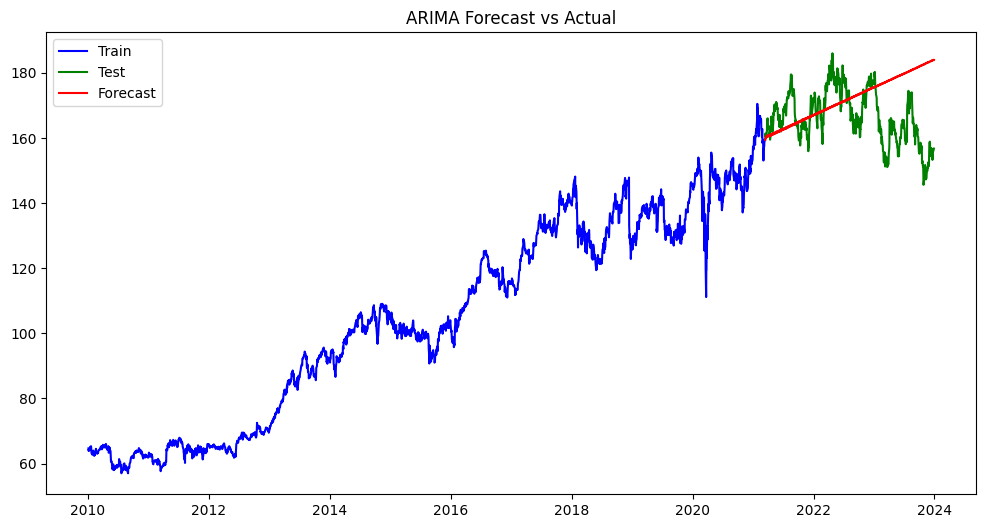

In [56]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["Close"], label='Train', color='blue')
plt.plot(test.index, test["Close"], label='Test', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

In [57]:
# Evaluate model performance on the test set
rmse = mean_squared_error(test["Close"], forecast, squared=False)
print(f"RMSE: {rmse}")

RMSE: 13.616270120555361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
